In [2]:
require(data.table)
require(tidyverse)
require(BiocParallel)
require(GenomicRanges)
require(Matrix)
require(chromVAR)
register(MulticoreParam(10, progressbar = TRUE))
require(Matrix.utils)
require(BSgenome.Hsapiens.UCSC.hg19)
require(SummarizedExperiment)
require(motifmatchr)


raw.data.folder <- '/Users/frank/mnt/tscc_home/data/projects/islet/2019-10_v2/'
res.data.folder <- '/Users/frank/mnt/tscc_home/scratch/projects/islet/2019-10_v2/'


### 0.filter reads in final cells & count reads per cell

In [10]:
# zcat islet.merged.filt.tagAlign.gz > islet.merged.filt.tagAlign
system.time(input.raw.reads <- fread(cmd = "gzcat ../dat/1910_v2/islet.merged.filt.tagAlign.gz", 
    header = FALSE))
input.raw.reads %>% head(1)
input.raw.reads %>% dim

   user  system elapsed 
327.463  58.099  68.440 

V1,V2,V3,V4,V5,V6
<chr>,<int>,<int>,<chr>,<int>,<chr>
chr1,750566,750766,Islet2fresh_CATGTCAGACTGAGCGTAAGCCTAGGC,36,+


[1] 129880638         6

In [12]:
setkey(input.raw.reads, V4)

system.time(output.reads.depth.per.cell <- input.raw.reads[, .(.N), by = .(V4)])

fwrite(output.reads.depth.per.cell, "../dat/1910_v2/output.reads.depth.per.cell.csv", 
    col.names = F)

output.reads.depth.per.cell%>%head(1)
output.reads.depth.per.cell%>%dim

V4,N
<chr>,<int>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,6135


[1] 15298     2

In [27]:
# zcat islet.merged.filt.tagAlign.gz > islet.merged.filt.tagAlign
input.cells.final <- fread(paste0(raw.data.folder, "islet.cluster_labels.filt.txt"), 
    header = T)
input.cells.final%>%head(1)
input.cells.final%>%dim

index,UMAP1,UMAP2,cluster_name,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 15298    11

In [29]:
input.raw.reads%>%pull(V4)%>%unique%>%length
all(input.raw.reads%>%pull(V4)%>%unique %in% input.cells.final$index)

[1] 15298

[1] TRUE

In [31]:
meta.data <- list()
meta.data$nreads <- input.raw.reads %>% nrow
meta.data$ncells <- input.cells.final %>% nrow

### 1. count reads in peaks (resized to 500bp)

* input: 1. peaks (255k) 2. filtered reads (128M reads) 3. cell-celltype dict (15k cells)
* output: 1. peaks x cells - sparse counts


In [37]:
input.peaks <- getPeaks(paste0(raw.data.folder, "islet.merged_peaks.anno.bed"), sort_peaks = T)
input.peaks %>% head(1)


Warning message in getPeaks(paste0(raw.data.folder, "islet.merged_peaks.anno.bed"), :
“Peaks are not equal width!Use resize(peaks, width = x, fix = "center") to make peaks equal in size, where x is the desired size of the peaks)”Peaks sorted


GRanges object with 1 range and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1 752579-752778      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [39]:
input.peaks <- resize(input.peaks,width=500,fix="center")
input.peaks <- as.data.table(input.peaks)[,.(seqnames,start,end)]
setkey(input.peaks,seqnames,start,end)
input.peaks%>%head(1)
input.peaks%>%dim

seqnames,start,end
<fct>,<int>,<int>
chr1,752429,752928


[1] 228873      3

In [43]:
input.raw.reads <- input.raw.reads[, .(V1, V2, V3, V4)]
input.raw.reads <- input.raw.reads[, .(seqnames = V1, start = V2, end = V3, cell = V4)]
input.raw.reads%>%head(1)
input.raw.reads%>%dim

seqnames,start,end,cell
<chr>,<int>,<int>,<chr>
chr1,750566,750766,Islet2fresh_CATGTCAGACTGAGCGTAAGCCTAGGC


[1] 129880638         4

In [45]:
system.time(output.peaks.by.cells.count <- foverlaps(input.raw.reads, input.peaks, 
    nomatch = 0L))
output.peaks.by.cells.count <- output.peaks.by.cells.count[,.(.N),by=.(seqnames,start,end,cell)]
output.peaks.by.cells.count <- output.peaks.by.cells.count[,cell:=as.factor(cell)]
output.peaks.by.cells.count <- output.peaks.by.cells.count %>% unite(col = peak,1:3)
output.peaks.by.cells.count <- output.peaks.by.cells.count[,peak:=as.factor(peak)]
output.peaks.by.cells.count%>%head(1)
output.peaks.by.cells.count%>%dim
fwrite(output.peaks.by.cells.count,"../dat/1910_v2/output.peaks.by.cells.count.csv")

   user  system elapsed 
 29.315   8.055  35.165 

peak,cell,N
<fct>,<fct>,<int>
chr1_752429_752928,Islet3fresh_ATTACTCGTCCTGAGCTTCTAGCTAGGCGAAG,1


[1] 39398882        3

In [47]:
rm(input.raw.reads)
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,8822522,471.2,14948888,798.4,NA,14948888,798.4
Vcells,135004610,1030.1,1210035988,9231.9,16384,1507410893,11500.7


In [34]:
colnames(input.peaks.by.cells.count.sparse) %>% head(1)
colnames(input.peaks.by.cells.count.sparse) <- sub("cell", "", colnames(input.peaks.by.cells.count.sparse))
colnames(input.peaks.by.cells.count.sparse) %>% head(1)
saveRDS(input.peaks.by.cells.count.sparse, "../dat/1910_v2/output.peaks.by.cells.count.sparse.Rdata")

[1] "Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC"

[1] "Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC"

In [48]:
#system.time(output.peaks.by.cells.count.sparse <- dMcast(output.peaks.by.cells.count, 
#    peak ~ cell, fun.aggregate = "I", value.var = "N"))

colnames(output.peaks.by.cells.count.sparse) <- sub("cell", "", colnames(output.peaks.by.cells.count.sparse))

# writeMM(output.peaks.by.cells.count.sparse,'output.peaks.by.cells.count.sparse.txt')
saveRDS(output.peaks.by.cells.count.sparse, "../dat/1910_v2/output.peaks.by.cells.count.sparse.Rdata")

   user  system elapsed 
 54.177   6.873  61.112 

### 2. creat count object for chromVar
* input: 1. peaks x cells - sparse counts 2. cell,read_depth 3. cell_type assignement
* output: 1. summarizedExperiement(SE) obj for chromVAR

In [56]:
input.peaks.by.cells.count.sparse<-readRDS("../dat/1910_v2/output.peaks.by.cells.count.sparse.Rdata")
input.reads.depth.per.cell<- fread("../dat/1910_v2/output.reads.depth.per.cell.csv",col.names = c("cell","depth"))
input.cell.celltypes <- read.table(paste0(raw.data.folder, "islet.cluster_labels.filt.txt"), 
    header = T,row.names = 1)

In [57]:
input.reads.depth.per.cell%>%head(1)
input.cell.celltypes%>%head(1)

cell,depth
<chr>,<int>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,6135


,UMAP1,UMAP2,cluster_name,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


In [58]:
# construct SE object  ----------------------------------------------------

output.SE.for.chromVar <- SummarizedExperiment(assays=list(counts=input.peaks.by.cells.count.sparse),
                    colData=input.reads.depth.per.cell)

rowRanges.gr <- do.call(rbind,sapply(rownames(output.SE.for.chromVar),strsplit,split="_"))
rowRanges.gr <- as.data.frame(rowRanges.gr)
colnames(rowRanges.gr)<- c("seqname","start","end")
rowRanges.gr <- makeGRangesFromDataFrame(rowRanges.gr)
rowRanges(output.SE.for.chromVar) <- rowRanges.gr


In [60]:
## filter sample  (skip)
#filtering_plot <- filterSamplesPlot(output.SE.for.chromVar, min_depth = 0, 
#                                    min_in_peaks = 0.15, use_plotly = FALSE)
#filtering_plot
output.SE.for.chromVar.filtered <- filterSamples(output.SE.for.chromVar, min_depth = 0, 
                                        min_in_peaks = 0, shiny = FALSE)

In [61]:
output.SE.for.chromVar%>%dim
output.SE.for.chromVar.filtered <- sort(output.SE.for.chromVar)
output.SE.for.chromVar.filtered <- filterPeaks(output.SE.for.chromVar.filtered)
output.SE.for.chromVar.filtered%>%dim

## add GC
output.SE.for.chromVar.filtered <- addGCBias(output.SE.for.chromVar.filtered, genome = BSgenome.Hsapiens.UCSC.hg19)

[1] 228873  15298

[1] 226677  15298

In [63]:
## add cell_type assignment 
cd <- colData(output.SE.for.chromVar.filtered)
cd$cell_type <- input.cell.celltypes[rownames(cd),"cluster_name"]
cd %>%head(1)
colData(output.SE.for.chromVar.filtered) <- cd
saveRDS(output.SE.for.chromVar.filtered,"../dat/1910_v2/output.SE.for.chromVar.filtered.Rdata")

DataFrame with 1 row and 3 columns
                                                                               cell
                                                                        <character>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC
                                              depth cell_type
                                          <integer>  <factor>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC      6135   alpha_2

In [69]:

rm(cd)
ls(all.names = T)
gc()

[1] ".pbd_env"                        ".Random.seed"                   
 [3] "input.cell.celltypes"            "input.motifs"                   
 [5] "input.reads.depth.per.cell"      "motif_ix"                       
 [7] "output.SE.for.chromVar.filtered" "raw.data.folder"                
 [9] "res.data.folder"                 "rowRanges.gr"

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,9401925,502.2,17536321,936.6,NA,17536321,936.6
Vcells,202051806,1541.6,607723673,4636.6,16384,724031548,5524.0


### 3 run chromVar

In [3]:
getJasparMotifs2018 <- function(species = "Homo sapiens", 
                              collection = "CORE", ...) {
  opts <- list()
#  opts["species"] <- species
  opts["collection"] <- collection
  opts["tax_group"] <- 'vertebrates'
  opts <- c(opts, list(...))
  out <- TFBSTools::getMatrixSet(JASPAR2018::JASPAR2018, opts)
  if (!isTRUE(all.equal(TFBSTools::name(out), names(out)))) 
    names(out) <- paste(names(out), TFBSTools::name(out), sep = "_")
  return(out)
}

In [4]:
# input.motifs <- getJasparMotifs()
input.motifs <- getJasparMotifs2018()
output.SE.for.chromVar.filtered <- readRDS("../dat/1910_v2/output.SE.for.chromVar.filtered.Rdata")

In [6]:
system.time(motif_ix <- matchMotifs(input.motifs, output.SE.for.chromVar.filtered, 
    genome = BSgenome.Hsapiens.UCSC.hg19))
dev <- computeDeviations(object = output.SE.for.chromVar.filtered, annotations = motif_ix)
tmp <- colData(dev)
tmp <- tmp %>% as.data.frame() %>% separate(cell_type, into = c("cell_type_overall", 
    "subtype"), remove = F, sep = "_")
tmp[is.na(tmp)] <- 0
colData(dev) <- DataFrame(tmp)
saveRDS(list(dev = dev, motif_ix = motif_ix), "../dat/1910_v2/output.jaspar.dev.res.Rdata")

   user  system elapsed 
 75.703   4.087  82.801 

  |======================================================================| 100%



Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

### 4. calculate variability 

#### 4.1 across all cell types

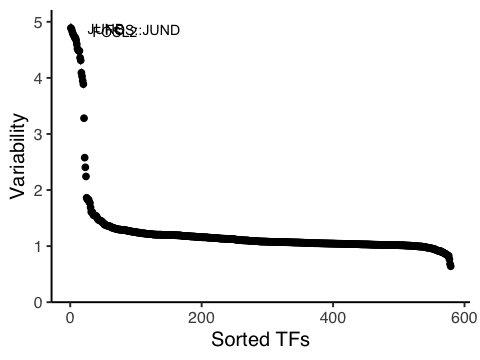

In [5]:
options(repr.plot.width = 4, repr.plot.height = 3)
tmp <- readRDS("../dat/1910_v2/output.jaspar.dev.res.Rdata")
dev <- tmp$dev
rm(tmp)
gc()
variability <- computeVariability(dev)

plotVariability(variability, use_plotly = FALSE)

In [10]:
dev%>%dim
variability%>%head(1)

[1]   579 15298

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0004.1_Arnt,Arnt,1.114364,1.1005,1.127908,2.729206e-86,6.24589e-86


In [16]:
fwrite(variability %>% arrange(desc(variability)), file = "../dat/1910_v2/output.jaspar.var.res.csv")